# install

In [111]:
!pip install lightgbm


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [112]:
!pip install scikit-learn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [113]:
!pip install -U scikit-learn lightgbm


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [114]:
import sklearn
print(sklearn.__version__)


1.7.2


# 파일 읽어오기

In [143]:
from pathlib import Path
import json, numpy as np, pandas as pd
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd

# 파일 읽어오기
candidates = [
    Path.cwd() / "app" / "data_pipeline",
    Path.cwd().parents[0] / "data_pipeline",
    Path.cwd().parents[0] / "app" / "data_pipeline",
    Path.cwd().parents[1] / "app" / "data_pipeline",
    Path("python-server/app/data_pipeline").resolve(),
]
BASE = next((p for p in candidates if p.exists()), None)
    
TR = BASE / "features_train.csv"
TE = BASE / "features_test.csv"
OUT_PRED    = BASE / "predictions.csv"
MODEL_PATH  = BASE / "lightgbm_model.pkl"
FEATS_JSON  = BASE / "lightgbm_features.json"
METRICS_CSV = BASE / "metrics_eval.csv"

ID_KEYS = ["warehouse_id","store_id","sku_id","region","target_date","split"]
TARGET = "y"
VAL_WEEKS = 12                  # 마지막 12주 검증
LEAKY = {"actual_order_qty", "share_norm", "promo_flag"}  # 누수 위험 피처는 제거하고 가져오기

print("BASE:", BASE)
print("Exists? TR:", TR.exists(), "TE:", TE.exists())


BASE: C:\Users\chosw\ORDER101_AI\be18-fin-SYNERGY-ORDER101\python-server\app\data_pipeline
Exists? TR: True TE: True


# 전처리
LightGBM 모델에 넣을 최종 학습 데이터셋을 만드는 전처리 단계
1. 누수 제거
2. 이전 주 플래그 생성
3. 수치형 피처만 자동 선택
4. ID/타깃 제거
5. 결측치 처리
6. 상수/저분산 피처 제거

## 모델 성능을 평가하기 위한 대칭 MAPE, 일반 MAPE 계산 함수
- 수요 데이터는 0값이 많음 -> 분모가 0이 되는 문제를 처리해야함. denom == 0이면 1로 대체.
- 예측 오차 비율을 직관적으로 보여줌


In [144]:
def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff  = np.abs(y_true - y_pred)
    denom = np.where(denom==0, 1.0, denom)
    return float(np.mean(diff / denom) * 100.0)
def mape(y_true, y_pred):
    denom = np.where(y_true==0, 1.0, y_true)
    return float((np.abs((y_true - y_pred) / denom)).mean() * 100.0)

## 데이터 누수 방지
- 사용 데이터의 프로모션 관련
- INPUT : 지난주에 프로모션 했는가?
- 이번 주 프로모션 여부인 promo_flag는 누수라 제거
- SKU 단위로 시계열 정렬되어 있다고 가정
- shift(1)로 한 주 미루기(데이터는 일주일 단위임) -> 지난주 값을 만듦
- 첫번째 row는 NaN임 -> 0으로 채우기
### 수요 예측 모델에서 현재 주의 실제 프로모션 여부를 피처로 넣으면 매래를 보는 누수 발생. -> 이전주만 사용

In [145]:
def add_prev_flags(df: pd.DataFrame) -> pd.DataFrame:
    if "promo_flag" in df.columns:
        df["promo_flag_prev"] = (
            df.groupby(["warehouse_id","store_id","sku_id"])["promo_flag"]
              .shift(1).fillna(0)
        )
    return df

## 모델 입력 피처 자동 생성
- 훈련 데이터에서 모델 입력으로 사용할 컬럼만 자동 선택
### 제외 컬럼
1. ID_KEYS  
   i. 그룹 구분용
2. actual_order_qty  
   i. y와 동일한 정보 -> 누수 및 과적합의 원인
3. TARGET("y")  
    i. 모델 타깃
4. 누수 위험 컬럼  
   i. share_norm : 실제 판매량 기반 비율이니깐 누수 요소임
   ii. promo_flag : 플래그

### 포함 컬럼
1. 수치형
   i. number, bool
2. 위의 제외 컬럼이 아닌것
3. 이전 주 플래그
   i. promo_flag_prev : promo_flag와 달리 이전 주 플래그

### 전처리 파이프라인 + 피처 자동 관리
### 새 컬럼이 생기거나 없어져도 자동으로 모델 적응

In [146]:
def build_features(df: pd.DataFrame) -> list:
    ignore = set(ID_KEYS + [TARGET, "actual_order_qty"])
    numeric_cols = set(df.select_dtypes(include=["number","bool"]).columns.tolist())
    feats = [c for c in df.columns if c in numeric_cols and c not in ignore and c not in LEAKY]
    if "promo_flag_prev" in df.columns and "promo_flag_prev" not in feats:
        feats.append("promo_flag_prev")
    # 중복 제거
    feats = list(dict.fromkeys(feats))
    return feats

## 저분산/상수 피처 제거
- 정보량이 없는 피처를 제거  
  -> 과적합 방지  
  -> 모델 효율 계선  
  -> noisy 피처 감소  
  
- 제거 기준
1. unique == 1
2. 분산이 0에 가까움 -> 거의 변하지 않는 값

In [147]:
def drop_low_variance(df_train: pd.DataFrame, cols, nunique_thresh=1, var_thresh=1e-8):
    nun = df_train[cols].nunique()
    low_nun = nun[nun <= nunique_thresh].index.tolist()
    var = df_train[cols].var(numeric_only=True).fillna(0.0)
    low_var = var[var <= var_thresh].index.tolist()
    drop = sorted(set(low_nun + low_var))
    keep = [c for c in cols if c not in drop]
    return keep, drop

## 실제 데이터 로딩/이전 주 플래그 생성/피처 자동 선택
- train / test dataset을 날짜 파싱하여 로드
- train과 test 모두 동일한 규칙으로 전처리
- 훈련 데이터 기준으로 feature set 결정
- test도 동일 feature를 사용하여 일관성 유지

In [148]:
tr = pd.read_csv(TR, parse_dates=["target_date"])
te = pd.read_csv(TE, parse_dates=["target_date"])

tr = add_prev_flags(tr); te = add_prev_flags(te)
features = build_features(tr)

## 결측치 처리
- LightGBM의 안정적인 입력을 위한 결측치 처리.
- 규칙
float/int → 0.0  
bool / int형 -> 0  
train/test 모두 동일 규칙 적용  

In [149]:
for c in features:
    if tr[c].dtype.kind in "fi":
        tr[c] = tr[c].fillna(0.0); te[c] = te[c].fillna(0.0)
    else:
        tr[c] = tr[c].fillna(0);   te[c] = te[c].fillna(0)

## 상수/저분산 피처 제거 후 최종 feature 리스트 확정
- 훈련 기준으로 제거  
- test에서도 동일한 feature set 사용해야함 -> feature만 바꿔줌

In [150]:
features, dropped = drop_low_variance(tr, features)
print("사용 피처 수:", len(features))
print(features)
if dropped:
    print("제거된 상수/저분산 피처:", dropped)

사용 피처 수: 37
['lag_1', 'lag_2', 'lag_4', 'lag_8', 'lag_12', 'ma_4', 'ma_8', 'ma_12', 'std_4', 'std_12', 'trend_1', 'trend_4', 'promo_flag_prev', 'year', 'weekofyear', 'month', 'sin_week', 'cos_week', 'avg_temp_c', 'cdd', 'hdd', 'precip_mm', 'heat_wave', 'cold_wave', 'himart_sales_krw', 'himart_sales_index', 'holiday_index', 'marketing_score', 'seasonal_peak', 'back_to_school', 'avg_temp_c_ma4', 'cdd_ma4', 'hdd_ma4', 'precip_mm_ma4', 'himart_sales_index_ma4', 'holiday_index_ma4', 'marketing_score_ma4']


# 시계열 검증 분리
- 마지막 12주를 검증 세트로
- keys: 하나의 시계열을 정의하는 그룹 단위
- sort_values(keys + ["target_date"])  
각 시계열이 시간순으로 정렬되어 있어야 “마지막 12주”를 잘 뽑을 수 있음.
- 정렬 기준:  
warehouse_id  
store_id  
sku_id  
target_date  

In [151]:
keys = ["warehouse_id","store_id","sku_id"]
tr2 = tr.sort_values(keys + ["target_date"]).copy()
# 각 그룹마다 시계열 인덱스 부여 (0, 1, 2...)
tr2["idx_in_grp"] = tr2.groupby(keys).cumcount()
# 각 그룹의 사이즈를 같은 그룹의 모든 row에 복사
tr2["grp_size"]   = tr2.groupby(keys)[TARGET].transform("size")
tr2["is_val"]     = (tr2["grp_size"] - tr2["idx_in_grp"]) <= VAL_WEEKS
tr_fit = tr2.loc[~tr2["is_val"]].drop(columns=["idx_in_grp","grp_size","is_val"])
tr_val = tr2.loc[ tr2["is_val"]].drop(columns=["idx_in_grp","grp_size","is_val"])

X_tr, y_tr = tr_fit[features], tr_fit[TARGET]
X_va, y_va = tr_val[features], tr_val[TARGET]

## LightGBM 모델 설정
- objective="poisson"  
  수요가 카운트 데이터 성격일때 자주 사용함    
  포아송 회귀는 비음수가 기본 가정.   
  수요 같은 스케일에 맞는 경우가 많아서 자연스러움   
- n_estimators=3000, learning_rate=0.02   
    부스팅 트리 개수(n_estimators)  
    한 번에 배우는 속도(learning_rate)  
    learning_rate를 낮게(0.02) 두고, n_estimators를 크게(3000) 둔 뒤,  
    early_stopping으로 적절한 트리 개수에서 stop 시켜서 안정적인 학습을 하고  
    과적합을 방지함  
- num_leaves=31, max_depth=8  
    num_leaves: 한 트리에서 만들 수 있는 리프 노드 최대 개수  
    클수록 복잡한 패턴을 잘 잡지만, 과적합  높음  
    max_depth: 각 트리의 최대 깊이  
    8이면 그리 깊지는 않지만, 그래도 어느 정도 비선형성은 표현 가능  
- min_child_samples=128  
    리프 노드 하나가 최소 몇개의 데이터를 가져야 하는지  
    값이 너무 크면 너무 소수인 데이터에 특화된 리프는 과적합을 가져와서 방지함  
    대신 세밀한 패턴을 덜 캐치함  
    -> 수요 예측은 데이터가 많고 노이즈도 많음  
- min_gain_to_split=0.02  
    트리를 분할할 때 얻는 gain이   
    0.02보다 작으면 더 이상 쪼개지 않도록 제한    
    너무 쓸데없는 분할(미미한 개선) 방지함 -> 일반화 성능에 도움.  
### 샘플링  
행 + 열을 둘다 랜덤 샘플링  
조금씩 다른 관점을 가진 트릴를 여러개 만들도록 한 구조임  
- subsample=0.65   
    각 트리를 만들 때 전체 데이터 중 65%만 랜덤 샘플링해서 사용.   
    과적합 방지용 (랜덤성 부여)  
- subsample_freq=1  
    매 트리마다 저 샘플링을 적용  
- colsample_bytree=0.65  
    각 트리를 만들 때 피처도 65%만 랜덤 선택해서 사용.  
### 규제  
- reg_alpha=2.0, reg_lambda=2.0  
    reg_alpha: L1 규제 (가중치에 절댓값 페널티)    
    reg_lambda: L2 규제 (L2, Ridge 스타일)    
    둘 다 2.0으로 준 건 꽤 강한 편의 정규화라서 과적합 감소  
    가중치가 너무 극단적으로 치우치는 것 방지  
### 재현성 & 로그  
- random_state=42, verbosity=-1    
    random_state=42: 결과 재현성을 위해 랜덤 시드 고정.  
    verbosity=-1: 학습 과정에서 불필요한 LightGBM 로그 숨김.  


In [152]:
model = LGBMRegressor(
    objective="poisson",
    n_estimators=3000, learning_rate=0.02,
    num_leaves=31, max_depth=8,
    min_child_samples=128,
    min_gain_to_split=0.02,
    subsample=0.65, subsample_freq=1,
    colsample_bytree=0.65,
    reg_alpha=2.0, reg_lambda=2.0,
    random_state=42, verbosity=-1
)



## 학습 + 얼리스타핑 설정
평가 지표로는 MAE(평균 절대 오차)를 사용
얼리스타핑으로 적절한 트리 개수를 자동으로 찾는다

In [153]:
model.fit(
    X_tr, y_tr,
    eval_set=[(X_va, y_va)],
    eval_metric="mae",
    callbacks=[early_stopping(15, first_metric_only=True), log_evaluation(200)]
)

best_iter = getattr(model, "best_iteration_", None)
print("best_iteration:", best_iter)

Training until validation scores don't improve for 15 rounds
[200]	valid_0's l1: 480.05	valid_0's poisson: -39695.6
[400]	valid_0's l1: 124.065	valid_0's poisson: -39724.8
[600]	valid_0's l1: 88.0202	valid_0's poisson: -39726.4
[800]	valid_0's l1: 76.398	valid_0's poisson: -39726.8
[1000]	valid_0's l1: 69.7373	valid_0's poisson: -39727
[1200]	valid_0's l1: 65.0318	valid_0's poisson: -39727.1
[1400]	valid_0's l1: 62.012	valid_0's poisson: -39727.1
[1600]	valid_0's l1: 59.922	valid_0's poisson: -39727.2
[1800]	valid_0's l1: 58.1263	valid_0's poisson: -39727.2
[2000]	valid_0's l1: 56.6999	valid_0's poisson: -39727.3
[2200]	valid_0's l1: 55.4569	valid_0's poisson: -39727.3
[2400]	valid_0's l1: 54.4335	valid_0's poisson: -39727.3
[2600]	valid_0's l1: 53.5565	valid_0's poisson: -39727.3
Early stopping, best iteration is:
[2764]	valid_0's l1: 52.9313	valid_0's poisson: -39727.3
Evaluated only: l1
best_iteration: 2764


# 학습된 모델로 test셋 전체 평가 및 SKU별로 성능 집계

- 테스트셋 예측/클리핑
- 테스트셋 전체 성능 평가
- SKU별 집계

1. 테스트셋 전체에 대해 예측 수행
2. 예측 결과를 0 이상으로 클리핑해서 현실적인 값으로 맞춘다
3. 테스트셋 전체 기준으로 MAE/MAPE/SMAPE 총괄 성능 계산
4. sku_is 단위로 다시 그룹핑해서 SKU별 데이터 개수와 SKU별 MAE를 구해서 상위 SKU들 기준으로 모델이 괜찮게 작동하는지 확인


클리핑 : 예측값이 음수가 나오면 강제로 0으로
- MAE : 평균 절대 오차   
MAE = 평균(|실제값 - 예측값|)
- MAPE : 평균 절대 백분율 오차  
MAPE = 평균( |실제 - 예측| / 실제 ) × 100%  
- SMAPE : MAPE의 문제(분모를 실제값만 사용하는 왜곡)을 해결한 버전   
SMAPE = 평균( |y_pred - y_true| / ((|y_pred| + |y_true|)/2) ) × 100%


In [154]:
te_pred = np.clip(model.predict(te[features], num_iteration=best_iter), 0, None)
te = te.copy()
te["y_pred"] = te_pred

mae   = mean_absolute_error(te[TARGET], te_pred)
_mape = mape(te[TARGET].values, te_pred)
_smape= smape(te[TARGET].values, te_pred)
print(f"MAE={mae:.4f} | MAPE={_mape:.2f}% | SMAPE={_smape:.2f}% (n={len(te)})")

sku_eval = (
    te.groupby("sku_id")
      .agg(n=("y","size"), mae=("y", lambda s: float(np.mean(np.abs(s - te.loc[s.index, "y_pred"])))))
      .sort_values("n", ascending=False)
)
sku_eval.head()


MAE=392.9624 | MAPE=30.80% | SMAPE=6.04% (n=33800)


,n,mae
sku_id,,
AC-CAR-16P-2024,520,99.707196
AC-LG-STAND-18P-2024,520,1217.394122
AC-LG-WS-6P-2024,520,32.499735
AC-SAM-WF-18P-2024,520,605.952306
AIR-LG-PURI-58-2024,520,1772.306433


# actual vs predict
SKU를 임의로 골라서 날짜별 실제 데이터와 예측 시계열을 확인 및 시각화

MAE for VAC-XIA-ROBO-2024: 5652.750 over 52 days


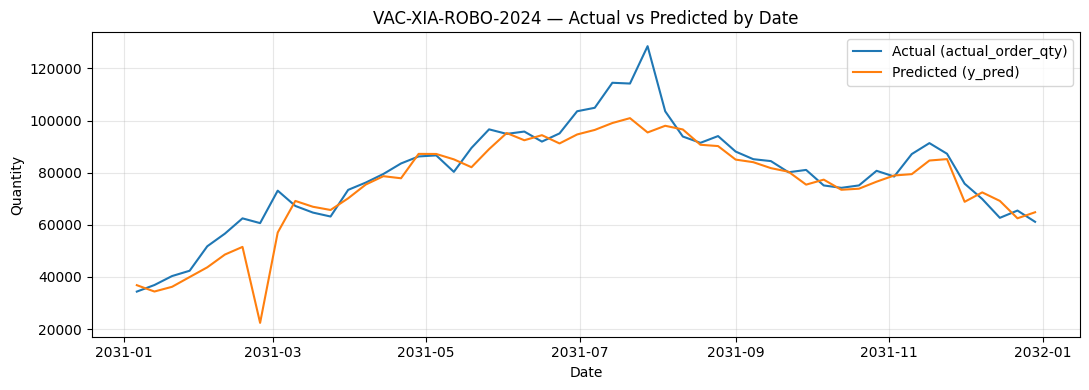

MAE for AC-CAR-16P-2024: 5493.192 over 52 days


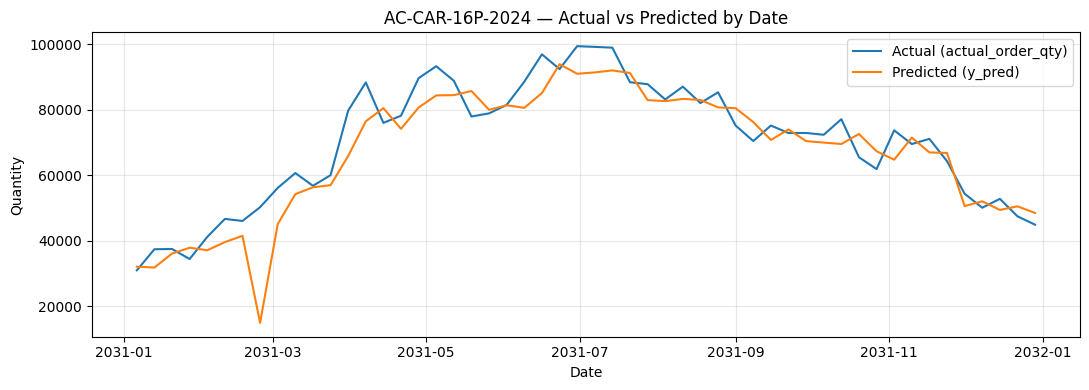

MAE for AC-LG-STAND-18P-2024: 16151.058 over 52 days


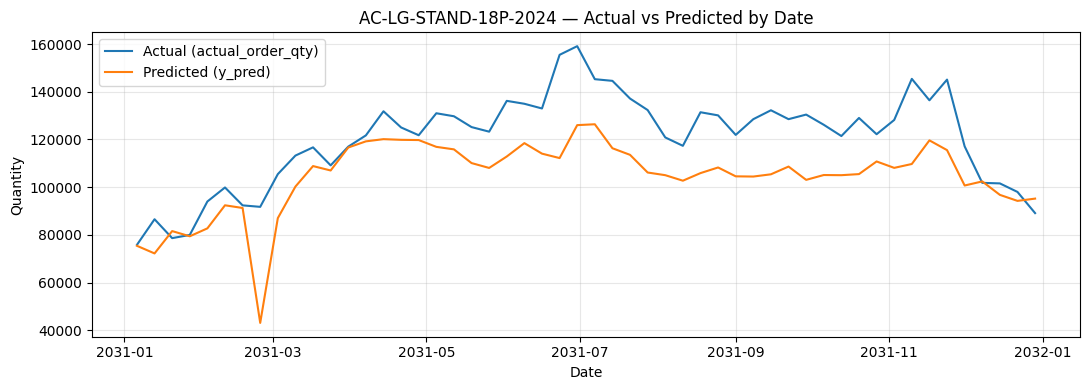

MAE for MON-DEL-24FHD-2023: 7305.500 over 52 days


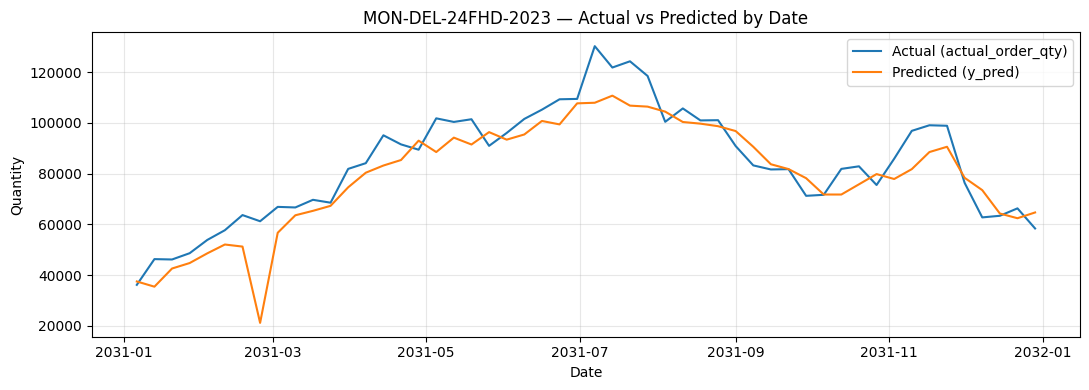

MAE for WM-MIE-DRUM-9K-2023: 3967.692 over 52 days


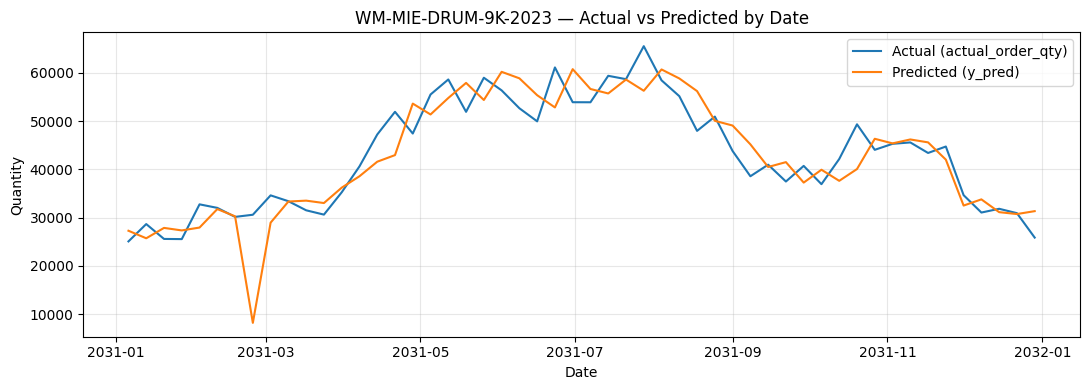

MAE for MIX-CUI-HAND-2024: 579.038 over 52 days


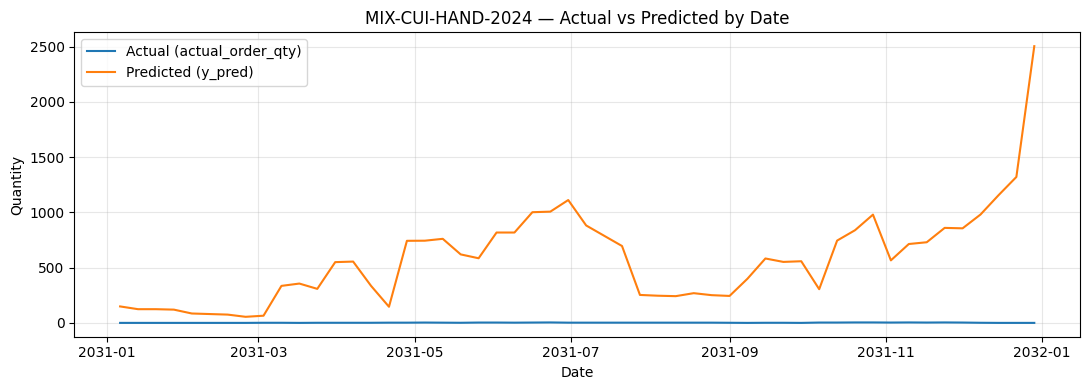

In [170]:
import pandas as pd
import matplotlib.pyplot as plt
def test(SKU):
    # --- file paths (edit if needed) ---
    FEATURES_PATH = BASE / "features_test.csv"
    PRED_PATH     = BASE / "predictions.csv"
    #SKU           = "VAC-XIA-ROBO-2024"
    
    # --- load ---
    feat = pd.read_csv(FEATURES_PATH, parse_dates=["target_date"])
    pred = pd.read_csv(PRED_PATH,     parse_dates=["target_date"])
    
    # --- filter SKU ---
    feat_sku = feat[feat["sku_id"] == SKU].copy()
    pred_sku = pred[pred["sku_id"] == SKU].copy()
    
    # --- aggregate by date in case there are multiple rows per target_date (e.g., by store/region) ---
    # features_test.csv: we expect "actual_order_qty"
    actual_by_day = (
        feat_sku.groupby("target_date", as_index=False)["actual_order_qty"]
        .sum()
        .rename(columns={"actual_order_qty": "y_actual"})
    )
    
    # predictions.csv: we expect "y_pred"
    pred_by_day = (
        pred_sku.groupby("target_date", as_index=False)["y_pred"]
        .sum()
    )
    
    # --- align by common dates (inner join) ---
    df = pd.merge(actual_by_day, pred_by_day, on="target_date", how="inner").sort_values("target_date")
    
    if df.empty:
        raise ValueError(f"No overlapping dates found for SKU={SKU}. "
                         "Check that both files contain this SKU and matching target_date values.")
    
    # --- (optional) quick metrics ---
    try:
        mae = (df["y_actual"] - df["y_pred"]).abs().mean()
        print(f"MAE for {SKU}: {mae:.3f} over {len(df)} days")
    except Exception as e:
        print("Could not compute MAE:", e)
    
    # --- plot ---
    plt.figure(figsize=(11, 4))
    plt.plot(df["target_date"], df["y_actual"], label="Actual (actual_order_qty)")
    plt.plot(df["target_date"], df["y_pred"],   label="Predicted (y_pred)")
    plt.title(f"{SKU} — Actual vs Predicted by Date")
    plt.xlabel("Date")
    plt.ylabel("Quantity")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


test("VAC-XIA-ROBO-2024")
test("AC-CAR-16P-2024")
test("AC-LG-STAND-18P-2024")
test("MON-DEL-24FHD-2023")
test("WM-MIE-DRUM-9K-2023")
test("MIX-CUI-HAND-2024")

# 결과 저장
최종적으로는 4개의 파일이 여기서 생성됨
| 파일                         | 내용                              | 용도                         |
| -------------------------- | ------------------------------- | -------------------------- |
| predictions.csv        | 실제값 + 예측값                       | 성능 분석, 그래프, 비교 분석          |
| lightgbm_model.pkl     | 학습된 모델 자체                       | FastAPI 추론 API, 재학습 없이 재사용 |
| lightgbm_features.json | 모델 입력에 사용된 컬럼 목록                | 재현성 확보, 추론 시 동일 피처 사용      |
| metrics_eval.csv       | MAE/MAPE/SMAPE + best_iteration | 모델 버전 관리, 성능 비교            |


In [156]:
# 예측 저장
keep_ids = [c for c in ["warehouse_id","store_id","sku_id","region","target_date"] if c in te.columns]
out = te[keep_ids + [TARGET, "y_pred"]].copy()
out["y_pred"] = out["y_pred"].round(0).astype(int)
out.to_csv(OUT_PRED, index=False)

# 모델/피처/메트릭 저장
import joblib
joblib.dump(model, MODEL_PATH)
with open(FEATS_JSON, "w", encoding="utf-8") as f:
    json.dump(features, f, ensure_ascii=False, indent=2)
pd.DataFrame({
    "metric":["mae","mape","smape"],
    "value":[mae, _mape, _smape],
    "best_iteration":[best_iter]*3
}).to_csv(METRICS_CSV, index=False)

print("saved:", OUT_PRED.name, "| model:", MODEL_PATH.name, "| feats:", FEATS_JSON.name, "| metrics:", METRICS_CSV.name)


saved: predictions.csv | model: lightgbm_model.pkl | feats: lightgbm_features.json | metrics: metrics_eval.csv


# 과적합 원인 찾기
overlap rows가 0이여야 과적합이 아니다

In [157]:
# 과적합 원인 찾기
print("Train date range:", tr["target_date"].min(), "→", tr["target_date"].max())
print("Test  date range:", te["target_date"].min(), "→", te["target_date"].max())

# 날짜 겹치는지
overlap = pd.merge(
    tr[["warehouse_id","store_id","sku_id","target_date"]],
    te[["warehouse_id","store_id","sku_id","target_date"]],
    on=["warehouse_id","store_id","sku_id","target_date"],
    how="inner"
)
print("overlap rows:", len(overlap))

# 피처에 누수 의심 변수 포함되어 있는지
suspect_cols = [c for c in features if any(k in c.lower() for k in ["order", "qty", "actual", "target"])]
print("누수 의심 피처:", suspect_cols)

# 이동평균 피처 확인
ma_cols = [c for c in features if "ma" in c.lower()]
print("이동평균 피처:", ma_cols)


Train date range: 2023-02-27 00:00:00 → 2030-12-30 00:00:00
Test  date range: 2031-01-06 00:00:00 → 2031-12-29 00:00:00
overlap rows: 0
누수 의심 피처: []
이동평균 피처: ['ma_4', 'ma_8', 'ma_12', 'himart_sales_krw', 'himart_sales_index', 'marketing_score', 'avg_temp_c_ma4', 'cdd_ma4', 'hdd_ma4', 'precip_mm_ma4', 'himart_sales_index_ma4', 'holiday_index_ma4', 'marketing_score_ma4']


# 예측 생성/ 테스트셋 정렬
y_pred가 없으면 예측 생성  
테스트셋 기본 정렬

In [158]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np

target = "y"
ignore = ["warehouse_id","store_id","sku_id","region","target_date","split",target]
leaky = {"actual_order_qty", "share_norm", "promo_flag"}  # 누출 방지

# --- (1) promo_flag_prev 안전 생성: 없을 때만 생성 ---
for df_ in (tr, te):
    if "promo_flag" in df_.columns and "promo_flag_prev" not in df_.columns:
        df_["promo_flag_prev"] = (
            df_.groupby(["warehouse_id","store_id","sku_id"])["promo_flag"]
              .shift(1).fillna(0)
        )

# --- (2) 피처 선택 + 중복 제거 ---
numeric_cols = tr.select_dtypes(include=["number","bool"]).columns.tolist()
features = [c for c in numeric_cols if c not in ignore and c not in leaky]
if "promo_flag_prev" in tr.columns:  # lag된 프로모만 사용
    features.append("promo_flag_prev")
# 중복 제거
features = list(dict.fromkeys(features))

print(f"사용 피처 수: {len(features)}개")
print(features)

# NaN 처리
for c in features:
    if tr[c].dtype.kind in "fi":
        tr[c] = tr[c].fillna(0.0); te[c] = te[c].fillna(0.0)
    else:
        tr[c] = tr[c].fillna(0);   te[c] = te[c].fillna(0)

# 학습
model = LGBMRegressor(
    n_estimators=1200, learning_rate=0.01,
    subsample=0.9, colsample_bytree=0.8,
    num_leaves=31, random_state=42
)
model.fit(tr[features], tr[target])

# 예측/평가
te_pred = np.clip(model.predict(te[features]), 0, None)
mae  = mean_absolute_error(te[target], te_pred)
mape = (np.abs(te[target] - te_pred) / np.maximum(te[target], 1)).mean() * 100
print(f"MAE={mae:.4f}, MAPE={mape:.2f}%")

사용 피처 수: 37개
['lag_1', 'lag_2', 'lag_4', 'lag_8', 'lag_12', 'ma_4', 'ma_8', 'ma_12', 'std_4', 'std_12', 'trend_1', 'trend_4', 'promo_flag_prev', 'year', 'weekofyear', 'month', 'sin_week', 'cos_week', 'avg_temp_c', 'cdd', 'hdd', 'precip_mm', 'heat_wave', 'cold_wave', 'himart_sales_krw', 'himart_sales_index', 'holiday_index', 'marketing_score', 'seasonal_peak', 'back_to_school', 'avg_temp_c_ma4', 'cdd_ma4', 'hdd_ma4', 'precip_mm_ma4', 'himart_sales_index_ma4', 'holiday_index_ma4', 'marketing_score_ma4']
MAE=359.6791, MAPE=140.93%


In [159]:
import numpy as np
import pandas as pd

target = "y"

# 아직 예측 안했다면 생성
if "y_pred" not in te.columns:
    te["y_pred"] = np.clip(model.predict(te[features]), 0, None)

# 기본 정렬
te = te.sort_values(["warehouse_id","store_id","sku_id","target_date"]).reset_index(drop=True)


# 모델 성능 파악  
SKU 단위로 모델 성능을 보는 단계    
커스텀 mape 사용함  -> 실제값이 0일때 MAPE는 무한대가 나와서  
SKU 단위로 모아서 지표 계산    
출력은 테스트 기간동안 판매량이 제일 많고 정확도가 상대적으로 높은 상위 10개 SKU  

In [160]:
# SKU 단위 MAE / MAPE 요약
def mape(a, p):
    denom = np.maximum(a, 1)  # 0-division 방지
    return (np.abs(a - p) / denom).mean() * 100

sku_eval = (te
    .groupby("sku_id")
    .apply(lambda g: pd.Series({
        "n": len(g),
        "qty_sum": g[target].sum(),
        "mae": np.abs(g[target]-g["y_pred"]).mean(),
        "mape": mape(g[target].values, g["y_pred"].values)
    }))
    .sort_values(["qty_sum","mape"], ascending=[False, True])
)
sku_eval.head(10)


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_34828\3793928618.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,n,qty_sum,mae,mape
sku_id,,,,
MIX-BRV-STAND-5L-2024,520.0,8665845.0,3539.801668,17.308404
MW-SAM-30L-2024,520.0,7072068.0,1777.200082,9.906788
AIR-LG-PURI-58-2024,520.0,6969534.0,1772.306433,10.245753
WM-LG-TOP-21K-2024,520.0,6761939.0,1707.993010,9.206640
FR-SAM-4D-820L-2024,520.0,6639728.0,1199.261910,7.305618
AC-LG-STAND-18P-2024,520.0,6563432.0,1217.394122,6.909386
DRY-SAM-GRN-20K-2024,520.0,6550685.0,1195.050274,7.091950
MW-LG-25L-2024,520.0,6152659.0,1024.574809,6.210107
TV-LG-OLED-65-2024,520.0,6116989.0,949.685979,5.872038


# 잔차 히스토그램/ Scatter Plot
### 잔차 히스토그램
각 테스트 데이터에 대해 실제값 - 예측값인 잔차값을 히스토그램으로 그림  
오차 분포 시각화
### Actual vs Predicted Scatter Plot
x축 = 실제값  
y축 = 예측값

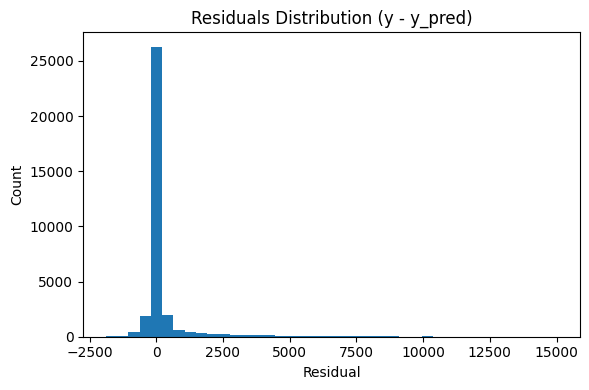

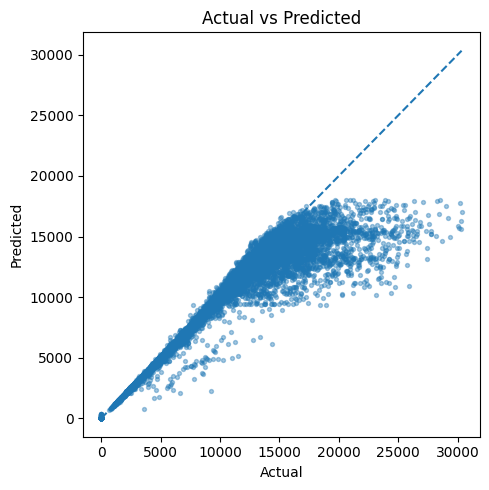

In [161]:
res = te[target] - te["y_pred"]

plt.figure(figsize=(6,4))
plt.hist(res, bins=40)
plt.title("Residuals Distribution (y - y_pred)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(te[target], te["y_pred"], s=8, alpha=0.4)
plt.plot([0, te[[target,'y_pred']].max().max()],
         [0, te[[target,'y_pred']].max().max()],
         linestyle="--")
plt.title("Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.tight_layout()
plt.show()


# 월별 모델 확인
월별로 모델이 잘 맞는지 or 특정 달에만 폭망하는지 보는것    
1. 과적합/언더핏을 “시간 축”에서 보는 진단 도구  
단순 전체 MAE/SMAPE만 보면 놓치는 패턴을 캐치 가능    
2. 계절성(seasonality) 문제점 파악 가능  
여름/겨울/명절 달에서만 터지는 오차를 체크     
3. 외부요인(feature 추가)의 효과를 검증하기 딱 좋은 구조    
before/after 두 버전 모델로 똑같은 그래프 그려서 비교하면 됨 
여름/겨울/명절 달에서만 터지는 오차를 체크   
  

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_34828\1095226514.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,year,month,n,mae,mape
0,2031,1,2600.0,42.451726,0.929098
1,2031,2,2600.0,93.721813,1.431522
2,2031,3,3250.0,150.385237,1.612667
3,2031,4,2600.0,314.782824,12.724147
4,2031,5,2600.0,480.125573,32.037093
5,2031,6,3250.0,637.191702,83.575228
6,2031,7,2600.0,826.566475,29.541269
7,2031,8,2600.0,719.626702,19.628616
8,2031,9,3250.0,492.762132,19.418463
9,2031,10,2600.0,352.118817,55.557953


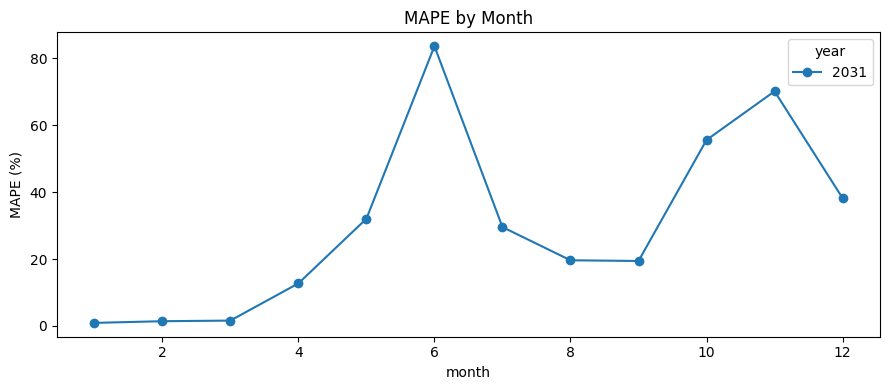

In [162]:
tmp = te.copy()
tmp["year"] = pd.to_datetime(tmp["target_date"]).dt.year
tmp["month"] = pd.to_datetime(tmp["target_date"]).dt.month
by_month = (tmp.groupby(["year","month"])
              .apply(lambda g: pd.Series({
                  "n": len(g),
                  "mae": np.abs(g[target]-g["y_pred"]).mean(),
                  "mape": mape(g[target].values, g["y_pred"].values)
              }))
              .reset_index())
display(by_month.sort_values(["year","month"]).head(24))

# 월별 MAPE 라인
pivot = by_month.pivot(index="month", columns="year", values="mape")
pivot.plot(figsize=(9,4), marker="o")
plt.title("MAPE by Month")
plt.ylabel("MAPE (%)")
plt.tight_layout()
plt.show()


# LightGBM feature importance 계산
모델이 어떤 피처를 얼마나 중요하게 사용했는지를 시각화
TOP20 중요 피처만 표로 출력

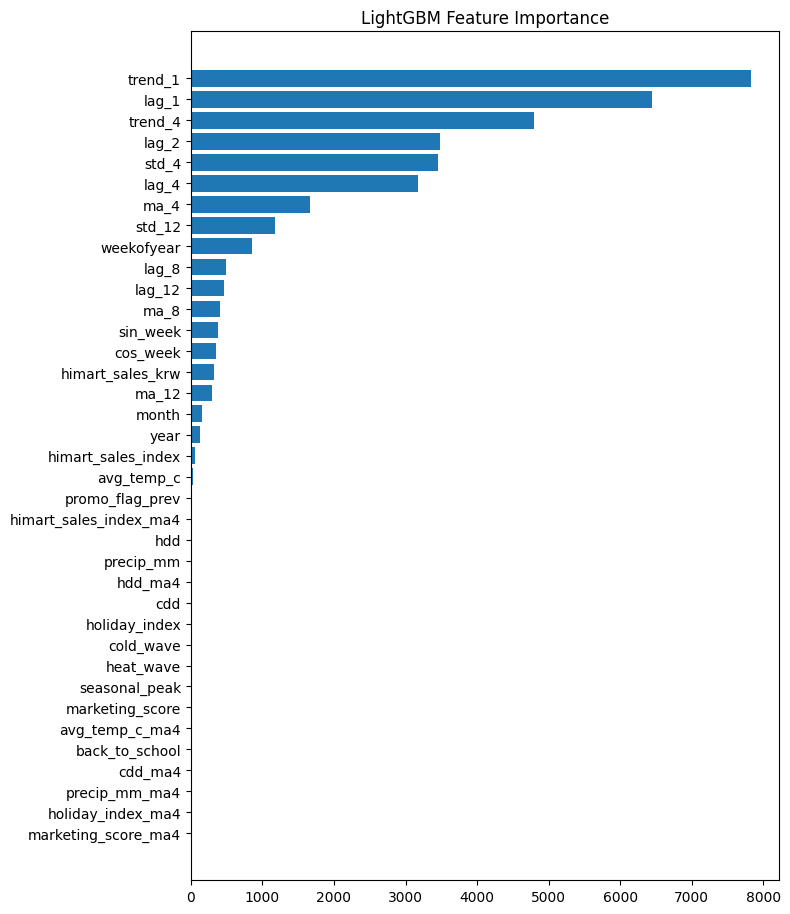

In [163]:
import numpy as np

if hasattr(model, "feature_importances_"):
    fi = pd.DataFrame({
        "feature": features,
        "importance": model.feature_importances_
    }).sort_values("importance", ascending=False)

    plt.figure(figsize=(8, max(4, 0.25*len(fi))))
    plt.barh(fi["feature"][::-1], fi["importance"][::-1])
    plt.title("LightGBM Feature Importance")
    plt.tight_layout()
    plt.show()

    fi.head(20)
else:
    print("모델이 feature_importances_를 제공하지 않습니다.")


# 상관 관계 체크
원시 도메인 판매 데이터에서 SKU들끼리 서로 얼마나 같이 움직이는지 체크  
1. domain_sales_sku.csv에서 SKU/날짜별 판매량 데이터를 불러옴
2. 그걸 날짜 × SKU 매트릭스로 바꿈
3. SKU들끼리 같은 날짜에서 판매량이 얼마나 같이 움직이는지 상관계수 구함
4. 그 전체 상관값의 중앙값 확인

In [164]:
import pandas as pd, pathlib as p
candidates = [
    Path.cwd() / "app" / "data_pipeline",
    Path.cwd().parents[0] / "data_pipeline",
    Path.cwd().parents[0] / "app" / "data_pipeline",
    Path.cwd().parents[1] / "app" / "data_pipeline",
    Path("python-server/app/data_pipeline").resolve(),
]
BASE = next((p for p in candidates if p.exists()), None)
df = pd.read_csv(BASE/"domain_sales_sku.csv", parse_dates=["target_date"])
print("SKU groups:", df["sku_id"].nunique())

# 같은 주차에서 SKU 간 상관이 너무 높지 않은지 대략 체크
g = (df.groupby(["sku_id","target_date"])["sku_qty"].sum().unstack(0).fillna(0))
print("Pairwise corr median:", g.corr().stack().median())


SKU groups: 65
Pairwise corr median: 0.978909077037394


In [165]:
sids = df["sku_id"].unique()[:2]
print(df[df["sku_id"].isin(sids)].pivot_table(
    index="target_date", columns="sku_id", values="sku_qty", aggfunc="sum").dropna().head(5))

sku_id       TV-LG-LED-55-2023  TV-LG-OLED-65-2024
target_date                                       
2023-02-28                   0                   0
2027-01-07               12607               32663
2027-01-14               12235               33851
2027-01-21               12840               34131
2027-01-28               11511               35179


# 시계열 개수

In [166]:
fa = pd.read_csv(BASE/"features_all.csv", parse_dates=["target_date"])
print("group ngroups:", fa.groupby(["warehouse_id","store_id","sku_id","region"]).ngroups)


group ngroups: 650


# SKU 간에 상관 관계 파악
데이터별로 추이가 같았기에 이를 수정 후 시각화해서 확인해보려고 작성함

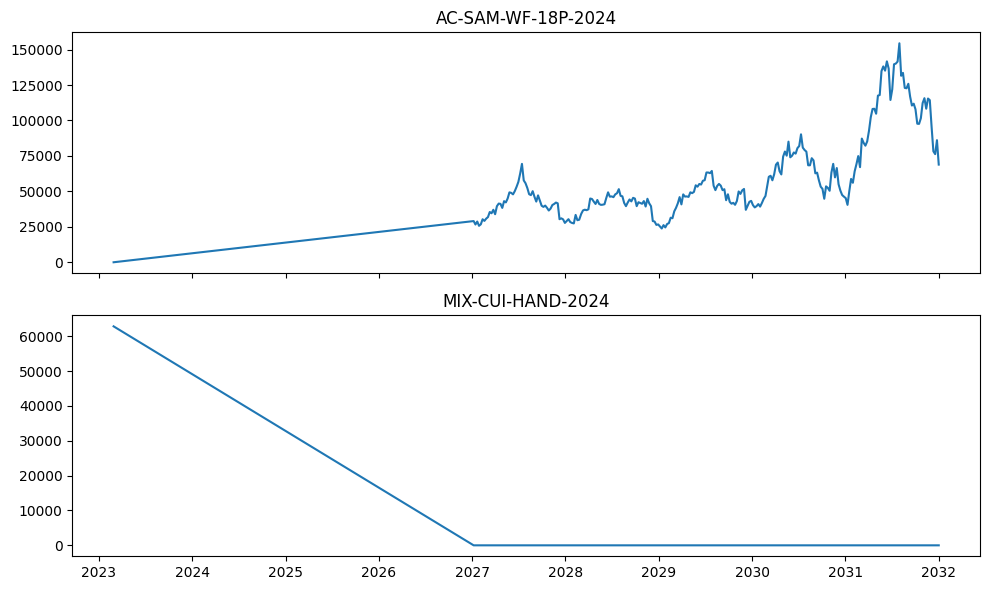

corr: -0.12537614833704255


In [169]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


candidates = [
    Path.cwd() / "app" / "data_pipeline",
    Path.cwd().parents[0] / "data_pipeline",
    Path.cwd().parents[0] / "app" / "data_pipeline",
    Path.cwd().parents[1] / "app" / "data_pipeline",
    Path("python-server/app/data_pipeline").resolve(),
]
BASE = next((p for p in candidates if p.exists()), None)

TR = BASE / "features_train.csv"
TE = BASE / "features_test.csv"
OUT_PRED    = BASE / "predictions.csv"
MODEL_PATH  = BASE / "lightgbm_model.pkl"
FEATS_JSON  = BASE / "lightgbm_features.json"
METRICS_CSV = BASE / "metrics_eval.csv"
DOMAIN_SALE = BASE / "domain_sales_sku.csv"
FEAT_ALL = BASE / "features_all.csv"



ds = pd.read_csv(DOMAIN_SALE, parse_dates=["target_date"])

pick = ds["sku_id"].drop_duplicates().sample(2, random_state=0).tolist()
fig, axes = plt.subplots(2,1, figsize=(10,6), sharex=True)
for ax, sid in zip(axes, pick):
    s = (ds[ds.sku_id==sid]
         .sort_values("target_date")
         .groupby("target_date")["sku_qty"].sum())
    ax.plot(s.index, s.values); ax.set_title(sid)
plt.tight_layout(); plt.show()

# 상관도(두 SKU가 너무 비슷하면 0.95↑)
s1 = (ds[ds.sku_id==pick[0]].sort_values("target_date")
        .groupby("target_date")["sku_qty"].sum())
s2 = (ds[ds.sku_id==pick[1]].sort_values("target_date")
        .groupby("target_date")["sku_qty"].sum())
joined = pd.concat([s1, s2], axis=1).dropna()
print("corr:", joined.corr().iloc[0,1])


# 점검용
오차 평균 체크

In [168]:
# rolling_backtest.py (요약)
import pandas as pd, numpy as np
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
import json, time, numpy as np, pandas as pd
from lightgbm import LGBMRegressor, early_stopping
from sklearn.metrics import mean_absolute_error

candidates = [
    Path.cwd() / "app" / "data_pipeline",
    Path.cwd().parents[0] / "data_pipeline",
    Path.cwd().parents[0] / "app" / "data_pipeline",
    Path.cwd().parents[1] / "app" / "data_pipeline",
    Path("python-server/app/data_pipeline").resolve(),
]
BASE = next((p for p in candidates if p.exists()), None)

TR = BASE / "features_train.csv"
TE = BASE / "features_test.csv"
OUT_PRED    = BASE / "predictions.csv"
MODEL_PATH  = BASE / "lightgbm_model.pkl"
FEATS_JSON  = BASE / "lightgbm_features.json"
METRICS_CSV = BASE / "metrics_eval.csv"
DOMAIN_SALE = BASE / "domain_sales_sku.csv"
FEAT_ALL = BASE / "features_all.csv"
LIGHTBGM_FEAT = BASE /"lightgbm_features.json"





# ---------------- params: 빠른 디버그용 ----------------
H               = 12      # 검증 창 (주)
MIN_TRAIN_WEEKS = 40
STEP_WEEKS      = 8       # 오리진 간격
MAX_SERIES      = 50      # 최대 시계열 개수
MAX_SPLITS      = 5       # 시계열당 최대 스플릿 수 (뒤에서부터)
MAX_SECONDS     = 120     # 전체 타임아웃(초)
# ------------------------------------------------------

keys = ["warehouse_id","store_id","sku_id"]

tr = pd.read_csv(TR, parse_dates=["target_date"])
te = pd.read_csv(TE, parse_dates=["target_date"])
df = pd.concat([tr, te], ignore_index=True).sort_values(keys + ["target_date"])

# --- 학습 때와 동일한 파생 ---
if "promo_flag" not in df.columns:
    df["promo_flag"] = (df.get("share_norm", 0) > 0.25).astype(int)
if "promo_flag_prev" not in df.columns:
    df["promo_flag_prev"] = (
        df.groupby(keys)["promo_flag"].shift(1).fillna(0).astype(int)
    )

# --- 피처 목록 로드 & 교집합 ---
with open(FEATS_JSON, "r", encoding="utf-8") as f:
    features = [c for c in json.load(f) if c in df.columns]

for c in features:
    df[c] = df[c].fillna(0.0) if df[c].dtype.kind in "fi" else df[c].fillna(0)

# --- 평가 대상 시계열 (상위 판매량 기준 일부만 샘플링) ---
vol = (df.groupby(keys)["y"].sum().sort_values(ascending=False))
series_list = [tuple(ix) for ix in vol.head(MAX_SERIES).index]

start = time.time()
maes, n_cases = [], 0

def iter_splits(g):
    dmin, dmax = g["target_date"].min(), g["target_date"].max()
    # 가능한 오리진들
    origins = pd.date_range(
        dmin + pd.Timedelta(weeks=MIN_TRAIN_WEEKS),
        dmax - pd.Timedelta(weeks=H),
        freq=f"{STEP_WEEKS}W-MON"
    )
    # 뒤에서부터 MAX_SPLITS개만
    return list(origins)[-MAX_SPLITS:]

for ser in series_list:
    g = df[(df["warehouse_id"]==ser[0]) & (df["store_id"]==ser[1]) & (df["sku_id"]==ser[2])]
    if len(g) < (MIN_TRAIN_WEEKS + H + 1): 
        continue

    for split in iter_splits(g):
        if time.time() - start > MAX_SECONDS:
            print(f"[STOP] time budget {MAX_SECONDS}s reached.")
            break

        train = g[g["target_date"] < split]
        val   = g[(g["target_date"] >= split) &
                  (g["target_date"] <  split + pd.Timedelta(weeks=H))]
        if len(train) < MIN_TRAIN_WEEKS or len(val) < H:
            continue

        m = LGBMRegressor(
            n_estimators=1500,        
            learning_rate=0.03,
            num_leaves=31, max_depth=8,
            subsample=0.8, colsample_bytree=0.7,
            min_child_samples=40,    
            reg_alpha=0.8, reg_lambda=1.0,
            random_state=42, verbose=-1
        )
        m.fit(
            train[features], train["y"],
            eval_set=[(val[features], val["y"])],
            eval_metric="mae",
            callbacks=[early_stopping(100, first_metric_only=True)]  # ES 단축
        )
        best_iter = getattr(m, "best_iteration_", None)
        pred = np.clip(m.predict(val[features], num_iteration=best_iter), 0, None)
        maes.append(mean_absolute_error(val["y"], pred))
        n_cases += 1
    if time.time() - start > MAX_SECONDS:
        break

print(f"Rolling MAE(mean) = {np.mean(maes):.4f} over {n_cases} folds" if maes else "No folds evaluated.")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[816]	valid_0's l1: 4831.4	valid_0's l2: 3.0174e+07
Evaluated only: l1
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	valid_0's l1: 7514.05	valid_0's l2: 5.96356e+07
Evaluated only: l1
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1496]	valid_0's l1: 7625.61	valid_0's l2: 6.26039e+07
Evaluated only: l1
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[445]	valid_0's l1: 4072.7	valid_0's l2: 1.96955e+07
Evaluated only: l1
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[97]	valid_0's l1: 1952.74	valid_0's l2: 6.64695e+06
Evaluated only: l1
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[691]	valid_0's l1: 4528.18	v